In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os

In [3]:
df = pd.read_json(os.path.join('condensed_2018.json'))
# df['polarity'] = df['class'].apply(lambda x : 1 if x == 'positive' else 0)
# class_names = ['negative', 'positive']

In [4]:
df.head()

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet
0,Twitter for iPhone,1079888205351145472,HAPPY NEW YEAR! https://t.co/bHoPDPQ7G6,2018-12-31 23:53:06+00:00,33548,NaN,136012,False
1,Twitter for iPhone,1079830268708556800,"....Senator Schumer, more than a year longer t...",2018-12-31 20:02:52+00:00,17456,25073877.0,65069,False
2,Twitter for iPhone,1079830267274108928,Heads of countries are calling wanting to know...,2018-12-31 20:02:52+00:00,21030,NaN,76721,False
3,Twitter for iPhone,1079763923845419008,It’s incredible how Democrats can all use thei...,2018-12-31 15:39:15+00:00,29610,NaN,127485,False
4,Twitter for iPhone,1079763419908243456,"I’m in the Oval Office. Democrats, come back f...",2018-12-31 15:37:14+00:00,30957,NaN,132439,False


In [5]:
# fig, ax = plt.subplots(figsize=(10, 8))
# sns.set(style="whitegrid")
# ax = sns.countplot(x="class", data=df)

## Preprocessing through Tokenizing and using TFIDF

In [6]:
### nltk and string transformations
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string

### sklearn
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, accuracy_score

### numpy for seed.  Good practice for reproducibility, not something we touched on but worth wild to look further.
import numpy as np
from numpy import random

SEED = 1234

random.seed(SEED)

Before anything we need to take raw text and convert to numerical inputs for the machine learning algorithms.

The first step is to split the sentences into words, we will do this through a method of Tokenization (or splitting).

In [7]:
### Define simple space tokenizer
translator = str.maketrans('', '', string.punctuation)
tk = tokenize.simple.SpaceTokenizer()

def simple_tokenizer(x):
    x = x.translate(translator).strip().lower()
    return tk.tokenize(x)

### Quick look at what the tokenizer produces
print(df['text'].head().apply(lambda x : simple_tokenizer(x)))

### Developing the corpus or list of sentences for processing later
corpus = df['text'].tolist()
corpus[0:5]

0               [happy, new, year, httpstcobhopdpq7g6]
1    [senator, schumer, more, than, a, year, longer...
2    [heads, of, countries, are, calling, wanting, ...
3    [it’s, incredible, how, democrats, can, all, u...
4    [i’m, in, the, oval, office, democrats, come, ...
Name: text, dtype: object


['HAPPY NEW YEAR! https://t.co/bHoPDPQ7G6',
 '....Senator Schumer, more than a year longer than any other Administration in history. These are people who have been approved by committees and all others, yet Schumer continues to hold them back from serving their Country! Very Unfair!',
 'Heads of countries are calling wanting to know why Senator Schumer is not approving their otherwise approved Ambassadors!? Likewise in Government lawyers and others are being delayed at a record pace! 360 great and hardworking people are waiting for approval from....',
 'It’s incredible how Democrats can all use their ridiculous sound bite and say that a Wall doesn’t work. It does, and properly built, almost 100%! They say it’s old technology - but so is the wheel. They now say it is immoral- but it is far more immoral for people to be dying!',
 'I’m in the Oval Office. Democrats, come back from vacation now and give us the votes necessary for Border Security, including the Wall. You voted yes in 2006 a

We will now use the tokenizer within the TFIDF vectorizer.  The words might sound intimidating yet simply yet in reality basically we just counting the number of times a words occur within the sentence relative to the whole sample (sometimes called a corpus).

In [19]:
vectorizer = TfidfVectorizer(tokenizer=simple_tokenizer, stop_words='english')
tf = vectorizer.fit(corpus)
X = tf.transform(corpus)

### Combining result of TFIDF with `target` columns
full_df = pd.concat([pd.DataFrame(X.toarray()), df['text']], axis=1)
print("Vector features : ", vectorizer.get_feature_names()[0:20])
print("Vector shape/size : ",X.shape)

Vector features :  ['', '\n', '\n\ndisaster', '\n\nheres', '\n\nhttpstcomazbcwoimy', '\n\nlisten', '\n\nread', '\n\nrealdonald…', '\n\nthank', '\n\nthis', '\n\nwe', '\n\n➡️', '\n45th', '\nadministrator', '\nchris', '\nevelyn', '\nhttpstco7cysybybd1', '\nhttpstcofurf2z6czl', '\nhttpstcol8wzer3uol', '\nhttpstcomp7icn0yzl']
Vector shape/size :  (3510, 9961)


Splitting data into a train and test datasets, using the predefined `SEED` from numpy for the split.

In [26]:
target_col = 'text'
X_train, X_test, y_train, y_test = train_test_split(full_df.drop(target_col, axis=1, y, test_size=0.20, random_state=SEED)
print(X_train.shape, y_train.shape)

SyntaxError: invalid syntax (<ipython-input-26-7644d431ad11>, line 3)

## Model Training and Analysis

**Helper Function**  : This is a simple helper function modified from the sklearn [documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html).  Example below.  Parameters required are the actual labels (y_true), the predicted labels (y_pred), classes in a list like `["good", "bad", "ugly"]`.  Options are using `normalize` to get percentages, `include_cm` to print off the raw confusion matrix, and `fig_size` for the size of the plot.

In [9]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          include_cm=False,
                          fig_size=(10, 8)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    from sklearn.utils.multiclass import unique_labels
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if include_cm:
        print(cm)

    fig, ax = plt.subplots(figsize=fig_size)
    ax.grid(False)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Lets use a base model to get a baseline prediction.

In [10]:
clf = MultinomialNB().fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [11]:
confusion_matrix(y_test, y_pred)

array([[76, 20],
       [19, 85]], dtype=int64)

In [12]:
print("Accuracy of base model is {:.2f} %".format(accuracy_score(y_test, y_pred)*100))

Accuracy of base model is 80.50 %


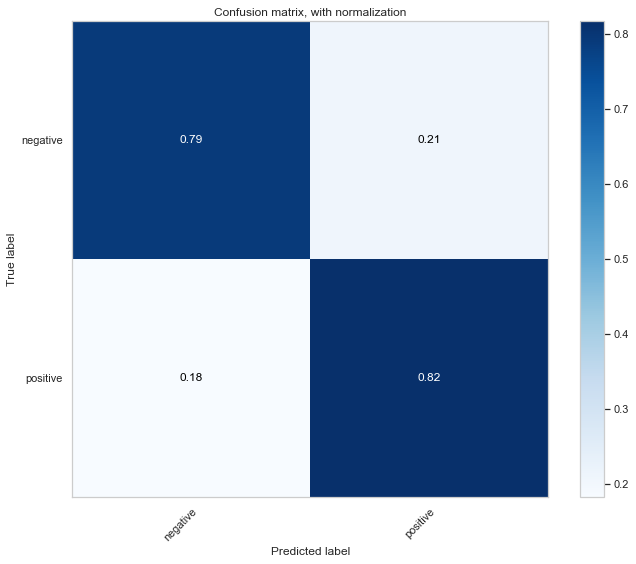

In [13]:
### Plot confusion matrix to get a feel for model ability to predict correct label.
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Confusion matrix, with normalization', fig_size=(10, 8));

**Another try**, let's try out using a Random Forest model.

In [14]:
clf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=SEED).fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [15]:
confusion_matrix(y_test, y_pred)

array([[89,  7],
       [43, 61]], dtype=int64)

In [16]:
print("Accuracy of base model is {:.2f} %".format(accuracy_score(y_test, y_pred)*100))

Accuracy of base model is 75.00 %


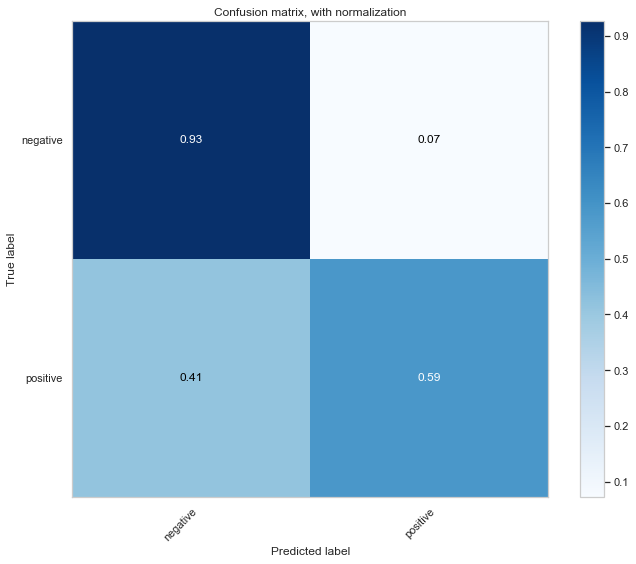

In [17]:
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Confusion matrix, with normalization', fig_size=(10, 8));

## Single Input Examples

In [18]:
review = "This food was absolutely the worst thing I have ever eaten, stomach thought I was eating Taco Bell and tongue thought I was eating dirt."

### Transform Review
review_transformed = tf.transform([review])

### Make Prediction
pred = clf.predict(review_transformed)

### Using the defined `class_names` get the predicted Polarity ( negative/positive )
print("Review was {}".format(class_names[pred[0]]))

Review was negative


In [19]:
review = "Best tacos I have ever had, will come back every Tuesday.  Will never go to any other taco shop again."

### Transform Review
review_transformed = tf.transform([review])

### Make Prediction
pred = clf.predict(review_transformed)

### Using the defined `class_names` get the predicted Polarity ( negative/positive )
print("Review was {}".format(class_names[pred[0]]))

Review was positive


## Extra Extra Content : Comparing Multiple Models Side by Side

Example found [here](https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f).  Interesting final reference.

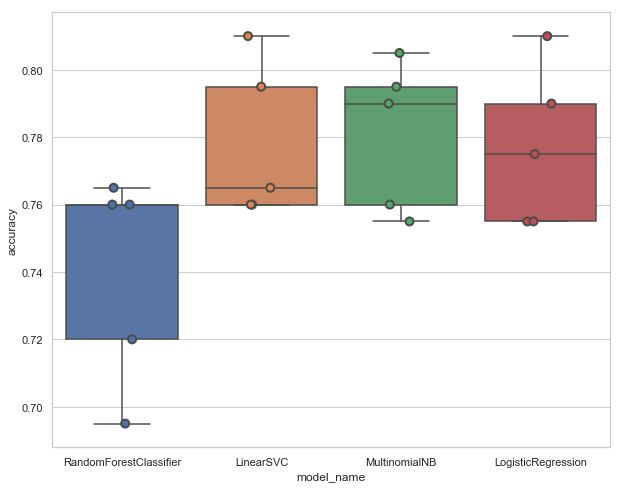

In [20]:
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=8, random_state=SEED),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0, solver='lbfgs'),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

### Gather all features (X values) and labels (y values) to pass through cross validation
features = full_df.drop(target_col, axis=1)
labels = df[target_col].values

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()